<a href="https://colab.research.google.com/github/Henkin2th/AIPI-590.05-Assignement/blob/main/AIPI590_Explainable_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Local Explanations Using LIME for a Pre-Trained ResNet34 Model

In this notebook, we will generate local explanations for a pre-trained ResNet34 model using the LIME (Local Interpretable Model-agnostic Explanations) technique. The model will classify an image, and LIME will explain the predictions by highlighting which parts of the image contributed most to the decision.


In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9b424282f8293786e9ad3c31d53fab28a1b9512b2e1703c2c74c088bcef485e9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO

import torch
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

### Load the ResNet34 Model

We will use a ResNet34 model pre-trained on ImageNet for image classification.

In [3]:
# Load pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Preprocess the Image

We will preprocess an image (resize, normalize) to ensure it is compatible with ResNet34.


In [4]:
# Preprocessing the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Load Image from URL

We will load an image from a GitHub repository and preprocess it.

In [5]:
url = 'https://github.com/Henkin2th/AIPI-590.05-Assignement/blob/main/Adversarial%20Patches/gr.jpg?raw=true'

# Load and preprocess a sample image
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img_tensor = preprocess(img).unsqueeze(0)

img_np = np.array(img)

### Define Prediction Function for LIME

The prediction function reshapes the image to match ResNet's input dimensions and returns the probabilities of the output classes.

In [6]:
def predict(img):
    model.eval()
    with torch.no_grad():
        img = torch.Tensor(img).permute(0, 3, 1, 2)  # Adjust dimensions for PyTorch model
        output = model(img)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Return probabilities
    return probabilities.numpy()

### Generate LIME Explanation

Now, we will generate a local explanation for the ResNet34 prediction using LIME.

In [9]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_np, predict, top_labels=1, hide_color=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Visualize LIME Explanation

We will visualize the LIME explanation by highlighting regions that contributed to the prediction.

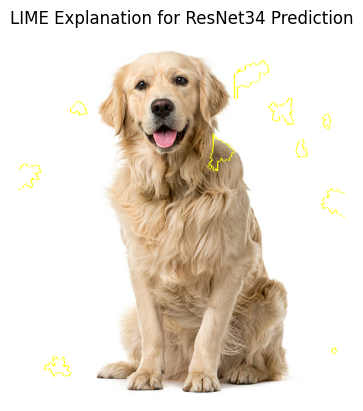

In [10]:
# Visualization
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation for ResNet34 Prediction")
plt.axis('off')
plt.show()

# Discussion: Result
It’s intriguing that LIME highlights a small portion of the dog’s fur as an important factor for ResNet34 in identifying the object in the image. Surprisingly, the model also seems to focus heavily on the white background. This might be because ResNet34 could be associating certain background patterns or contrasts with the object’s shape or features, which often happens with pre-trained models when trained on a diverse dataset like ImageNet. The model might misinterpret background details as part of the subject, especially when such features frequently co-occur with specific objects.

### Discussion: Why LIME?

**LIME** was chosen because it is a flexible, model-agnostic tool that provides local explanations for individual predictions, making it easier to interpret decisions made by complex models like ResNet34.

#### Strengths:
- **Interpretability**: Provides human-readable explanations.
- **Model-agnostic**: Works with any machine learning model.
  
#### Limitations:
- **Computationally Expensive**: LIME requires many perturbations of the input to approximate the decision boundary.
- **Approximation**: LIME approximates complex models with linear surrogates, which may not capture all nuances.

#### Improvements:
- Combining LIME with more robust explanation methods like SHAP could provide more accurate feature attributions.
